['r507c04n04', 'r514c07n03']
47080076 47080076.0
0.081896312 0.081893133
3.1789999999920493e-06


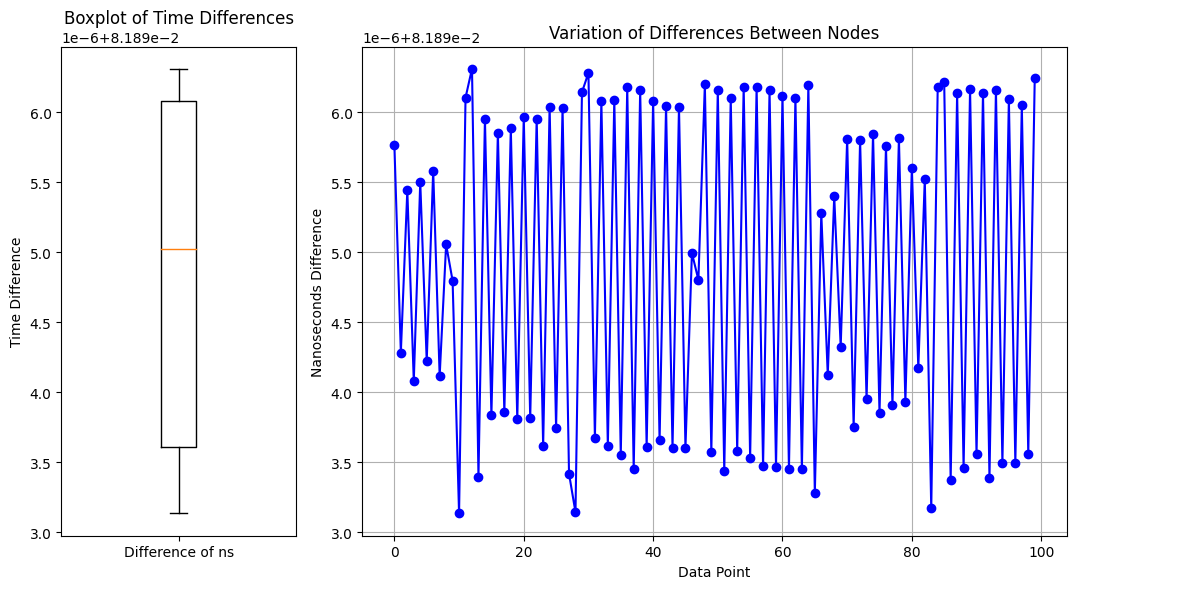

In [6]:
import re,os
from collections import defaultdict
import numpy as np
import statistics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Host r507c06n04  , Rank 001: seconds 1357236, nanosecond 136250940
# Host r507c06n01  , Rank 000: seconds 1357226, nanosecond 50537229
pattern=r'Host (\w+)  , Rank (\d+): seconds (\d+), nanosecond (\d+)'
received_data =defaultdict(list)
hosts=[]
file_path= os.path.join(f'timeshift.data')
with open(file_path, 'r') as file: 
        for line in file:
            match = re.search(pattern, line)
            if match:
                host,_,second,nanosecond = match.groups()
                received_data[host].append((int(second), int(nanosecond)))
                if host not in hosts :hosts.append(host)
print(hosts)

differences = []
differences_second =[]

for (sec1, ns1), (sec2, ns2) in zip(received_data[hosts[0]], received_data[hosts[1]]):
    diff_sec = sec2 - sec1
    diff_ns = ns2 - ns1
    if diff_ns < 0:
        diff_sec -= 1
        diff_ns += 1000000000
    differences.append((diff_ns/1e9))
    differences_second.append((diff_sec))
    
print(differences_second[0],np.average(differences_second)) 
print(max(differences),min(differences))
print(max(differences)-min(differences))

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 3, 0.2])
ax1 = plt.subplot(gs[0])
ax1.boxplot([differences], labels=['Difference of ns'])
ax1.set_title('Boxplot of Time Differences')
ax1.set_ylabel('Time Difference')
ax2 = plt.subplot(gs[1])
ax2.plot(differences, marker='o', linestyle='-', color='b')
ax2.set_title('Variation of Differences Between Nodes')
ax2.set_xlabel('Data Point')
ax2.set_ylabel('Nanoseconds Difference')
ax2.grid(True)
ax3 = plt.subplot(gs[2])
ax3.axis('off')
plt.tight_layout()
plt.show()

### Data cleaning


In [7]:
import numpy as np
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

differences_cleaned = []

lower_bound, upper_bound = calculate_iqr(differences)
differences_cleaned = [x for x in differences if lower_bound <= x <= upper_bound]

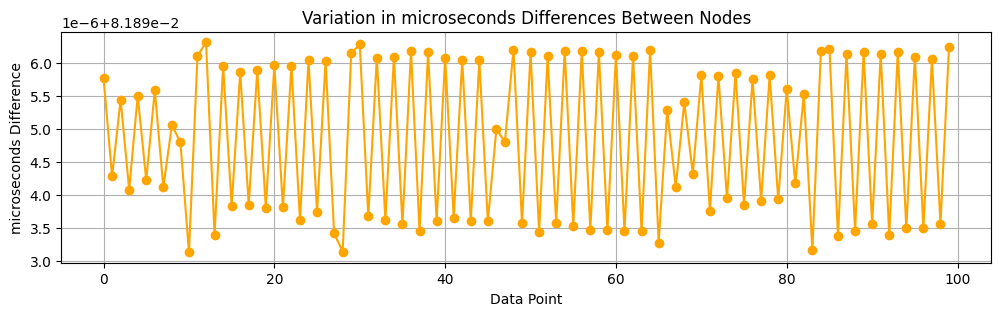

In [8]:
plt.figure(figsize=(12, 3))
plt.plot(differences_cleaned, marker='o', linestyle='-', color='orange')
plt.title('Variation in microseconds Differences Between Nodes')
plt.xlabel('Data Point')
plt.ylabel('microseconds Difference')
plt.grid(True)
plt.show()

## Moda

0.081895956
0.08189484761999997


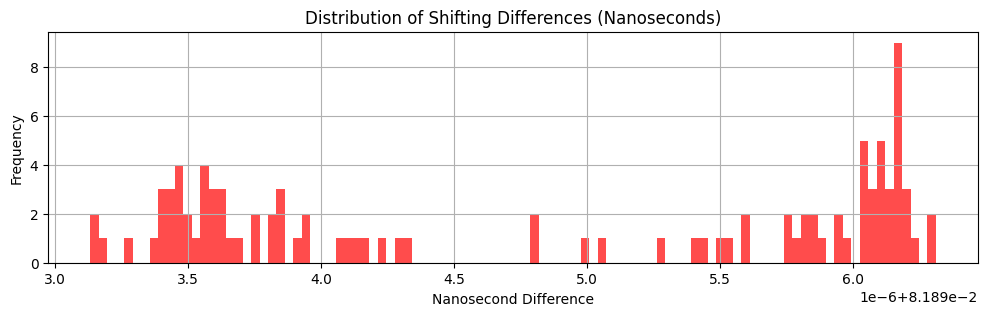

In [12]:
mode = statistics.mode(differences)
print(mode)

avg=np.average(differences)
print(avg); mode=avg
plt.figure(figsize=(12, 3))
plt.hist(differences, bins=100, color='red', alpha=0.7)
plt.title('Distribution of Shifting Differences (Nanoseconds)')
plt.xlabel('Nanosecond Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
sec_diff=np.average(differences_second)
print(received_data[hosts[0]][0],(sec_diff,mode*1e9),"",end='')

sec=received_data[hosts[0]][0][0]+sec_diff

if received_data[hosts[0]][0][1]+mode*1e9 > 1e9: ns=received_data[hosts[0]][0][1]+mode*1e9-1e9;sec+=1; print("+1s")
else: ns=received_data[hosts[0]][0][1]+mode*1e9; print("+0s")
print(sec,ns)


(1882965, 27310887) (47080076.0, 81895956.0) +0s
48963041.0 109206843.0


### Code on cineca:

``` python
import re,os,glob
from collections import defaultdict, Counter
import statistics

file_pattern = "timeshift*.data"
matching_files = glob.glob(f"./{file_pattern}")
n=len(matching_files)
pattern=r'Host (\w+)\s*, Rank (\d+): seconds (\d+), nanosecond (\d+)'
received_data =defaultdict(list)
hosts=[]
for file_path in matching_files:
    with open(file_path, 'r') as file: 
            for line in file:
                match = re.search(pattern, line)
                if match:
                    host,_,second,nanosecond = match.groups()
                    received_data[host].append((int(second), int(nanosecond)))
                    if host not in hosts :hosts.append(host)
print()
for host in hosts:
    print(host, "len:", len(received_data[host]))

differences = []
differences_second =[]

for (sec1, ns1), (sec2, ns2) in zip(received_data[hosts[0]], received_data[hosts[1]]):
    diff_sec = sec2 - sec1
    diff_ns = ns2 - ns1
    if diff_ns < 0:
        diff_sec -= 1
        diff_ns += 1000000000
    differences.append((diff_ns/1e9))
    differences_second.append((diff_sec))
    
try: mode = statistics.mode(differences)
except:  
    c = Counter(differences)
    mode= c.most_common(1)[0][0]
# print(mode)
sec_diff= statistics.mean(differences_second)
#print(received_data[hosts[0]][0],(sec_diff,mode*1e9),"",end='')

sec=received_data[hosts[0]][0][0]+sec_diff

if received_data[hosts[0]][0][1]+mode*1e9 > 1e9: ns=received_data[hosts[0]][0][1]+mode*1e9-1e9;sec+=1#; print("+1s")
else: ns=received_data[hosts[0]][0][1]+mode*1e9#; print("+0s")
print(f'Difference {hosts[0]} - {hosts[1]} :{(sec_diff,mode*1e9)}\n{hosts[0]}: {received_data[hosts[0]][0]}\n{hosts[1]}: ({sec},{ns})')
if n == 3:
    for (sec1, ns1), (sec2, ns2) in zip(received_data[hosts[0]], received_data[hosts[2]]):
        diff_sec = sec2 - sec1
        diff_ns = ns2 - ns1
        if diff_ns < 0:
            diff_sec -= 1
            diff_ns += 1000000000
        differences.append((diff_ns/1e9))
        differences_second.append((diff_sec))
        
    try: mode = statistics.mode(differences)
    except:  
        c = Counter(differences)
        mode= c.most_common(1)[0][0]
    sec_diff= statistics.mean(differences_second)
    sec=received_data[hosts[0]][0][0]+sec_diff

    if received_data[hosts[0]][0][1]+mode*1e9 > 1e9: ns=received_data[hosts[0]][0][1]+mode*1e9-1e9;sec+=1#; print("+1s")
    else: ns=received_data[hosts[0]][0][1]+mode*1e9#; print("+0s")
    print(f'Difference {hosts[0]} - {hosts[2]} :{(sec_diff,mode*1e9)}\n{hosts[2]}: ({sec},{ns})\n')
```
